In [1]:
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
import keras

from keras.layers import TextVectorization, Dense, Conv1D, Embedding, Dropout, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping

In [2]:
data = pd.read_csv("master_dataset/processed_data.csv")
data.head()

,title,text,class,text_without_stopwords,title_without_stopwords,text_word_count,title_word_count,text_sentence_count,title_sentence_count,text_average_word_length,...,polarity,overall_content,Topic 1 Probability,Topic 2 Probability,Topic 3 Probbility,Topic 4 Probability,Topic 5 Probability,polarity_category,polarity_category_Neutral,polarity_category_Positive
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1,donald trump wish americans happy new year lea...,donald trump sends out embarrassing new year’s...,516,13,28,1,4.804040,...,0.082132,donald trump sends out embarrassing new year’s...,0.002194,0.747636,0.001007,0.157660,0.091503,Positive,0,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1,house intelligence committee chairman devin nu...,drunk bragging trump staffer started russian c...,309,9,11,1,5.213115,...,-0.005004,drunk bragging trump staffer started russian c...,0.064904,0.244962,0.557051,0.002320,0.130763,Neutral,1,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1,on friday revealed former milwaukee sheriff da...,sheriff david clarke becomes an internet joke ...,600,16,25,1,5.168966,...,-0.012345,sheriff david clarke becomes an internet joke ...,0.002488,0.433611,0.281460,0.001917,0.280524,Neutral,1,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1,on christmas day donald trump announced would ...,trump is so obsessed he even has obama’s name ...,475,15,15,1,5.180180,...,-0.023118,trump is so obsessed he even has obama’s name ...,0.002963,0.788261,0.204377,0.002290,0.002109,Neutral,1,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1,pope francis used annual christmas day message...,pope francis just called out donald trump duri...,434,12,19,1,4.554762,...,-0.011722,pope francis just called out donald trump duri...,0.292172,0.327938,0.001138,0.020911,0.357842,Neutral,1,0


In [3]:
#first split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(data['overall_content'], data['class'], test_size = 0.2, random_state = 4222)

x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.25, random_state = 4222)

y_train.value_counts()

0    12717
1    10477
Name: class, dtype: int64

In [4]:
lst = [len(item.split()) for item in x_train]
big_list = [item.split() for item in x_train]
unique = list(set([item for sublist in big_list for item in sublist]))

In [5]:
print(len(unique)) # How many different words are there
print(max(lst)) # What the maximum word in an article 

207463
5130


(array([2.1596e+04, 1.4800e+03, 7.0000e+01, 2.4000e+01, 1.2000e+01,
        4.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([2.0000e+00, 5.1480e+02, 1.0276e+03, 1.5404e+03, 2.0532e+03,
        2.5660e+03, 3.0788e+03, 3.5916e+03, 4.1044e+03, 4.6172e+03,
        5.1300e+03]),
 <BarContainer object of 10 artists>)

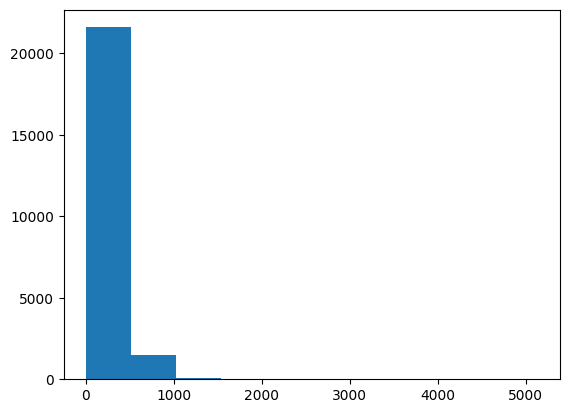

In [6]:
import matplotlib.pyplot as plt
plt.hist(lst)

In [7]:
batch_size = 32

raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (tf.constant(x_train.squeeze().to_list()),
     tf.keras.utils.to_categorical(y_train.to_numpy()-1))
).batch(batch_size)

raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (tf.constant(x_test.squeeze().to_list()),
     tf.keras.utils.to_categorical(y_test.to_numpy()-1))
).batch(batch_size)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (tf.constant(x_validation.squeeze().to_list()),
     tf.keras.utils.to_categorical(y_validation.to_numpy()-1))
).batch(batch_size)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Number of batches in raw_train_ds: 725
Number of batches in raw_val_ds: 242
Number of batches in raw_test_ds: 242


In [8]:
# Model constants.
max_features = 40000
embedding_dim = 100
sequence_length = 1000
maxlen = [500, 1000]
dense_units = [64, 128]
lstm_units = [64, 128]

vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, _ : x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)

In [9]:
candidate_params = list(itertools.product(maxlen, dense_units, lstm_units))
print(candidate_params)

[(500, 64, 64), (500, 64, 128), (500, 128, 64), (500, 128, 128), (1000, 64, 64), (1000, 64, 128), (1000, 128, 64), (1000, 128, 128)]


In [10]:
def tokenized_sets(maxlen):
    results = []
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(x_train.squeeze())

    tokenized_train = tokenizer.texts_to_sequences(x_train.squeeze())
    x_train_tokenized = pad_sequences(tokenized_train , maxlen=maxlen)
    results.append(x_train_tokenized)

    tokenized_val = tokenizer.texts_to_sequences(x_validation)
    x_validation_tokenized = pad_sequences(tokenized_val , maxlen=maxlen)
    results.append(x_validation_tokenized)

    tokenized_test = tokenizer.texts_to_sequences(x_test)
    x_test_tokenized = pad_sequences(tokenized_test , maxlen=maxlen)
    results.append(x_test_tokenized)

    return results

In [11]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

In [12]:
def cnn_model(cnn_units, dense_units):

    model = keras.models.Sequential()

    # Next, we add a layer to map those vocab indices into a space of dimensionality 'embedding_dim'.
    model.add(Embedding(max_features, embedding_dim))
    model.add(Dropout(0.5))

    # Conv1D + global max pooling
    model.add(Conv1D(cnn_units, 7, padding="valid", activation="relu", strides=3))
    model.add(Conv1D(cnn_units, 7, padding="valid", activation="relu", strides=3))
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(0.5))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(1, activation="sigmoid", name="predictions"))

    # Compile the model with binary crossentropy loss and an adam optimizer.
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

    return model

In [13]:
epochs = 3

early_stopping = EarlyStopping()

def make_predictions(tokenized_text, model):
    model.fit(tokenized_text[0], y_train,
                  validation_data = (tokenized_text[1], y_validation),
                  epochs = epochs,
                  callbacks = [early_stopping])
    y_pred = (model.predict(tokenized_text[2]) >= 0.5).astype("int")
    return y_pred

In [14]:
for parameters in candidate_params:
    count = 1
    accuracy = 0
    best_params = []
    data = tokenized_sets(parameters[0])
    cnn = cnn_model(parameters[1], parameters[2])
    predictions = make_predictions(data, cnn)
    accuracy_current = accuracy_score(y_test, predictions)
    if accuracy_current > accuracy:
        accuracy = accuracy_current
        best_params = parameters 
print(best_params)

Epoch 1/3
725/725 [==============================] - 30s 40ms/step - loss: 0.1617 - accuracy: 0.9130 - val_loss: 0.0278 - val_accuracy: 0.9911
Epoch 2/3
242/242 [==============================] - 1s 2ms/step
Epoch 1/3
725/725 [==============================] - 29s 40ms/step - loss: 0.1511 - accuracy: 0.9173 - val_loss: 0.0384 - val_accuracy: 0.9869
Epoch 2/3
725/725 [==============================] - 29s 40ms/step - loss: 0.0130 - accuracy: 0.9967 - val_loss: 0.0362 - val_accuracy: 0.9893
Epoch 3/3
242/242 [==============================] - 1s 2ms/step
Epoch 1/3
725/725 [==============================] - 31s 42ms/step - loss: 0.1398 - accuracy: 0.9291 - val_loss: 0.0256 - val_accuracy: 0.9924
Epoch 2/3
242/242 [==============================] - 1s 3ms/step
Epoch 1/3
725/725 [==============================] - 31s 42ms/step - loss: 0.1231 - accuracy: 0.9384 - val_loss: 0.0348 - val_accuracy: 0.9881
Epoch 2/3
725/725 [==============================] - 30s 42ms/step - loss: 0.0093 - accura

In [15]:
final_sets = tokenized_sets(best_params[0])
final_cnn_model = cnn_model(best_params[1], best_params[2])

history = final_cnn_model.fit(final_sets[0], y_train,
                              validation_data = (final_sets[1], y_validation),
                              epochs = epochs, 
                              callbacks = [early_stopping])

y_pred = (final_cnn_model.predict(final_sets[2]) >= 0.5).astype("int")

Epoch 1/3
725/725 [==============================] - 64s 87ms/step - loss: 0.1396 - accuracy: 0.9249 - val_loss: 0.0201 - val_accuracy: 0.9934
Epoch 2/3
242/242 [==============================] - 4s 15ms/step


In [16]:
print("Performance on Test set:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1_score:", f1_score(y_test, y_pred))

Performance on Test set:
Accuracy: 0.9918520434557683
Precision: 0.9985481997677119
Recall: 0.983414355161567
F1_score: 0.9909234980550352
